In [61]:
# Imports
import random

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from IPython.display import display
from torch.utils.data import DataLoader, TensorDataset

# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.
# NOTE: This is mostly a GPU free tutorial.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

# SEED = 2021
# set_seed(seed=SEED)
# DEVICE = set_device()

In [62]:
class Net(nn.Module):
  """
  Initialize MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: list
        Number of units per hidden layer, list of integers
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshaping later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one

      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      layer = nn.Linear(in_num, out_num) # Use nn.Linear to define the layer
      in_num = out_num # Assign next layer input using current layer output
      self.mlp.add_module('Linear_%d'%i, layer) # Append layer to the model with a name

      actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module('Activation_%d'%i, actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    logits = self.mlp(x) # Forward pass of MLP
    return logits



input = torch.zeros((100, 2))
## Uncomment below to create network and test it on input
net = Net(actv='LeakyReLU(0.1)', input_feature_num=2, hidden_unit_nums=[100, 10, 5], output_feature_num=1).to(DEVICE)
y = net(input.to(DEVICE))
print(f'The output shape is {y.shape} for an input of shape {input.shape}')

The output shape is torch.Size([100, 1]) for an input of shape torch.Size([100, 2])


In [63]:

def cross_entropy_loss(x, labels):
  """
  Helper function to compute cross entropy loss

  Args:
    x: torch.tensor
      Model predictions we'd like to evaluate using labels
    labels: torch.tensor
      Ground truth

  Returns:
    avg_loss: float
      Average of the loss vector
  """
  x_of_labels = torch.zeros(len(labels))
  # 1. Prediction for each class corresponding to the label
  for i, label in enumerate(labels):
    x_of_labels[i] = x[i, label]
  # 2. Loss vector for the batch
  losses = -x_of_labels + torch.log(torch.sum(torch.exp(x), axis=1))
  # 3. Return the average of the loss vector
  avg_loss = losses.mean()

  return avg_loss



labels = torch.tensor([0, 1])
x = torch.tensor([[10.0, 1.0, -1.0, -20.0],  # Correctly classified
                  [10.0, 10.0, 2.0, -10.0]])  # Not correctly classified
CE = nn.CrossEntropyLoss()
pytorch_loss = CE(x, labels).item()
## Uncomment below to test your function
our_loss = cross_entropy_loss(x, labels).item()
print(f'Our CE loss: {our_loss:0.8f}, Pytorch CE loss: {pytorch_loss:0.8f}')
print(f'Difference: {np.abs(our_loss - pytorch_loss):0.8f}')

Our CE loss: 0.34672737, Pytorch CE loss: 0.34672749
Difference: 0.00000012


## Spiral Classification Dataset



Random seed 2021 has been set.


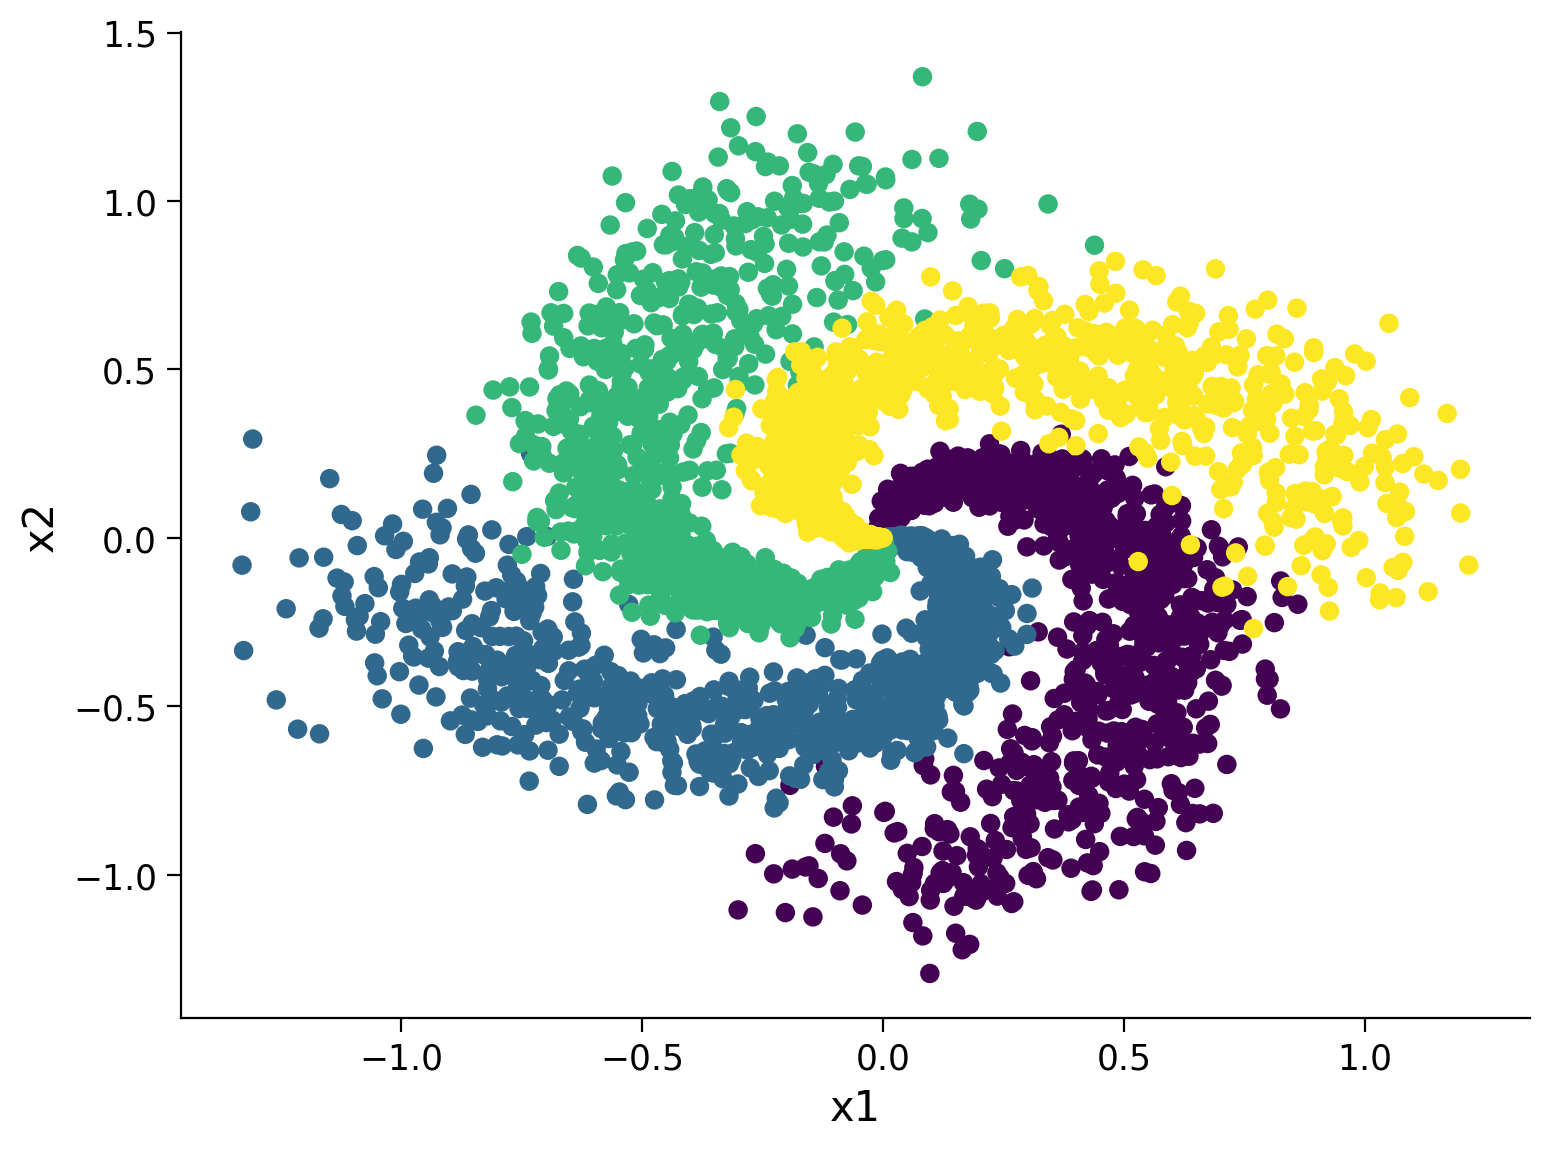

In [64]:
def create_spiral_dataset(K, sigma, N):
  """
  Function to simulate spiral dataset

  Args:
    K: int
      Number of classes
    sigma: float
      Standard deviation
    N: int
      Number of data points

  Returns:
    X: torch.tensor
      Spiral data
    y: torch.tensor
      Corresponding ground truth
  """

  # Initialize t, X, y
  t = torch.linspace(0, 1, N)
  X = torch.zeros(K*N, 2)
  y = torch.zeros(K*N)

  # Create data
  for k in range(K):
    X[k*N:(k+1)*N, 0] = t*(torch.sin(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
    X[k*N:(k+1)*N, 1] = t*(torch.cos(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
    y[k*N:(k+1)*N] = k

  return X, y


# Set parameters
K = 4
sigma = 0.16
N = 1000

set_seed(seed=SEED)
X, y = create_spiral_dataset(K, sigma, N)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

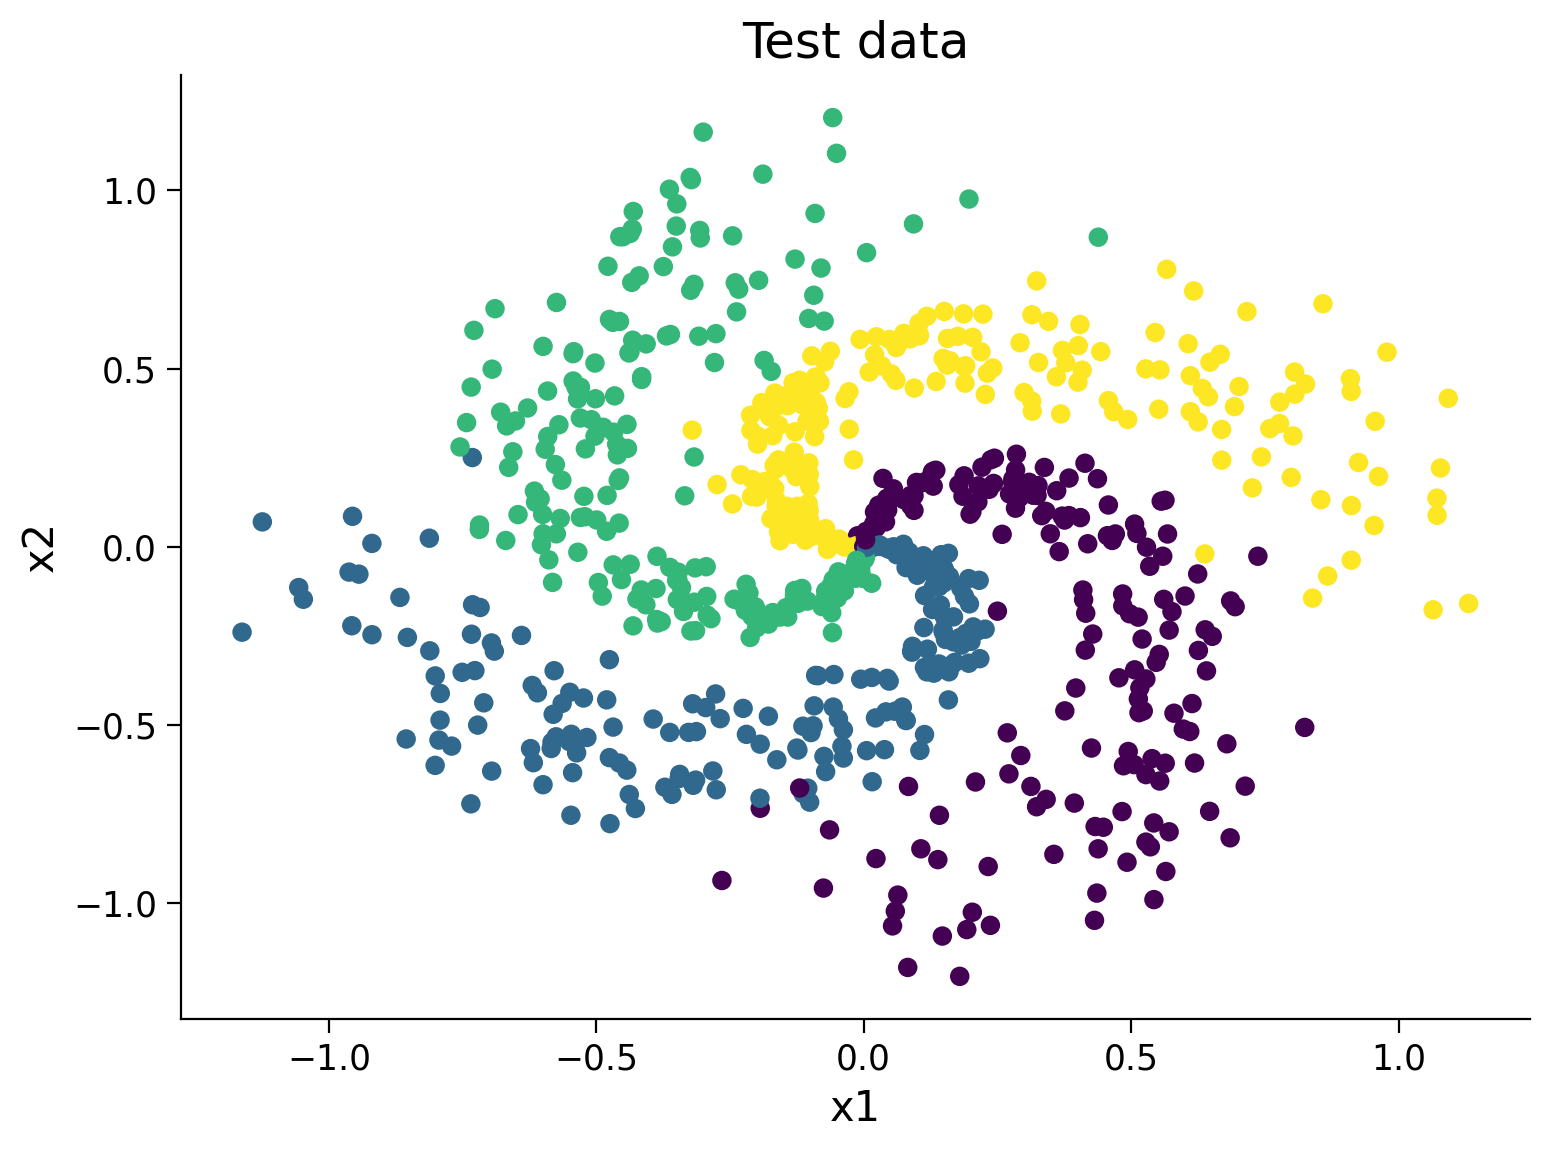

In [65]:
def shuffle_and_split_data(X, y, seed):
  """
  Helper function to shuffle and split incoming data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[0]
  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(.2 * N)    # Assign test datset size using 20% of samples
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train



## Uncomment below to test your function
X_test, y_test, X_train, y_train = shuffle_and_split_data(X, y, seed=SEED)
plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Test data')
plt.show()


And we need to make a Pytorch data loader out of it. Data loading in PyTorch can be separated in 2 parts:

- Data must be wrapped on a Dataset parent class where the methods getitem and len must be overrided. Note that, at this point, the data is not loaded on memory. PyTorch will only load what is needed to the memory. Here TensorDataset does this for us directly.
- Use a Dataloader that will actually read the data in batches and put into memory. Also, the option of num_workers > 0 allows multithreading, which prepares multiple batches in the queue to speed things up.

In [66]:
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

batch_size = 128
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=2,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=2,
                          worker_init_fn=seed_worker,
                          generator=g_seed)

Note that model.train() tells your model that you are training the model. So layers like dropout, batch norm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly. And to turn off training mode we set model.eval().

In [67]:
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False, device='cpu'):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    Nothing
  """
  net.train() # training mode..
  training_losses = []
  for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Print statistics
      if verbose:
        training_losses += [loss.item()]

  net.eval() # testing mode..

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print(f"Accuracy on the {train_total} training samples: {train_acc:0.2f}")
    print(f"Accuracy on the {test_total} testing samples: {test_acc:0.2f}")

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc

In [68]:
set_seed(SEED)
net = Net('ReLU()', X_train.shape[1], [128], K).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 100

_, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)

Random seed 2021 has been set.


  0%|          | 0/100 [00:00<?, ?it/s]

Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
    exitcode = _main(fd, parent_sentinel)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
  File "/usr/local/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
    self = reduction.pickle.load(fro

RuntimeError: DataLoader worker (pid(s) 4421) exited unexpectedly